In [1]:
import numpy as np
import scipy.fftpack as spfft
from sklearn.linear_model import Lasso
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import scipy

In [2]:
map_size = 100

In [3]:
map_bmp = np.array(Image.open(f'{map_size}x{map_size}_block.bmp'))

In [4]:
my_map = np.empty((map_size, map_size), dtype=np.short)
my_map[:] = 0
my_map[map_bmp] = 255
map_bmp = my_map


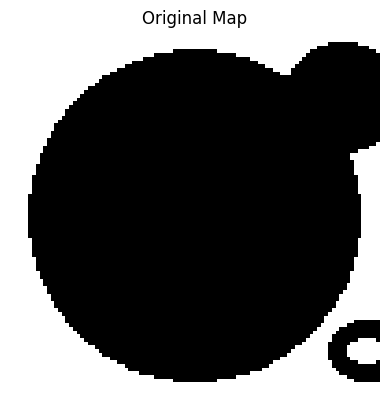

In [5]:
plt.figure()
img = plt.imshow(map_bmp)
img.set_cmap('gray')
plt.axis('off')
plt.title(f'Original Map')
plt.show()

In [6]:
# create dct matrix operator using kron (memory errors for large ny*nx)
ny, nx = map_bmp.shape
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
lasso = Lasso(alpha=0.0001)

In [7]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [8]:
def cs_predict(fig, sample_ratio):

    # Reconstruct qtable
    X = fig
    ny, nx = X.shape
    
    # extract small sample of signal
    k = int(np.round(nx * ny * sample_ratio))
    
    # state_action_distribution = learner.visits/np.sum(learner.visits)
    # SAdist_sorted = np.sort(state_action_distribution.flatten())
    # threshold_prob = SAdist_sorted[int(np.floor((1-sample_ratio)*len(SAdist_sorted)))]
    # ri = np.where(state_action_distribution.flatten() > threshold_prob)[0]
    
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
    b = X.T.flat[ri]
    b = np.expand_dims(b, axis=1)

    # compression matrix @ transform matrix
    Ac = A[ri,:] # same as phi times kron

    # lasso = Lasso(alpha=0.001)
    
    lasso.fit(Ac, b)

    # Reconstruct qtable
    Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns
    # Get the reconstructed qtable
    Xa = idct2(Xat)

    return Xa

In [9]:
# # Reconstruct qtable
# X = map_bmp
# ny, nx = X.shape

In [10]:
# # extract small sample of signal
# sample_ratio = 0.3
# k = int(np.round(nx * ny * sample_ratio))

In [11]:
# # state_action_distribution = learner.visits/np.sum(learner.visits)
# # SAdist_sorted = np.sort(state_action_distribution.flatten())
# # threshold_prob = SAdist_sorted[int(np.floor((1-sample_ratio)*len(SAdist_sorted)))]
# # ri = np.where(state_action_distribution.flatten() > threshold_prob)[0]

# ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
# b = X.T.flat[ri]
# b = np.expand_dims(b, axis=1)

In [12]:
# # Visualize
# bviz = np.zeros_like(X.flatten())
# bviz[ri] = X.T.flat[ri]

# bviz = bviz.reshape(X.T.shape)
# plt.figure()
# img = plt.imshow(bviz.T,cmap='gray')
# img.set_cmap('gray')
# plt.axis('off')
# plt.title(f'Measured Map')
# plt.show()

In [13]:
# # compression matrix @ transform matrix
# Ac = A[ri,:] # same as phi times kron

# # lasso = Lasso(alpha=0.001)
# lasso = Lasso(alpha=0.01)
# lasso.fit(Ac, b)

# # Reconstruct qtable
# Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns
# # Get the reconstructed qtable
# Xa = idct2(Xat)

In [14]:
# plt.imshow(Xa,cmap='gray')
# plt.axis('off')
# plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e+02, tolerance: 9.175e+01
  model = cd_fast.enet_coordinate_descent(


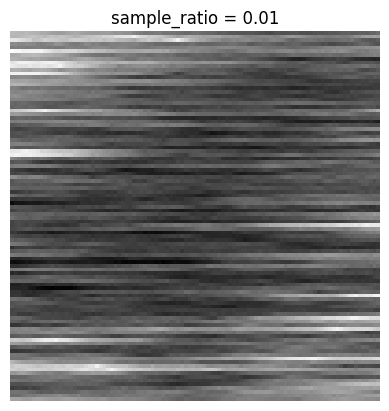

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.976e+02, tolerance: 2.782e+02
  model = cd_fast.enet_coordinate_descent(


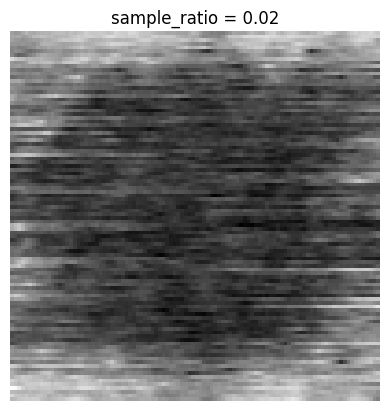

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.283e+03, tolerance: 7.296e+02
  model = cd_fast.enet_coordinate_descent(


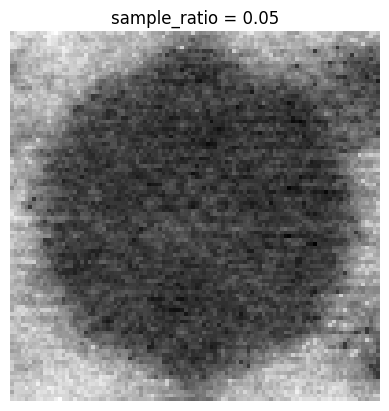

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e+03, tolerance: 1.424e+03
  model = cd_fast.enet_coordinate_descent(


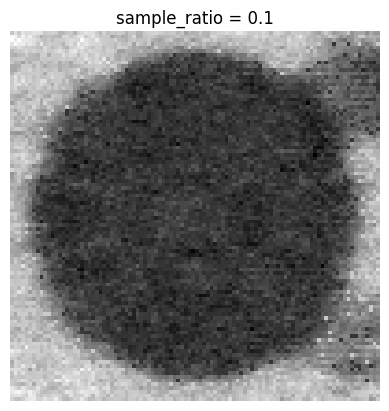

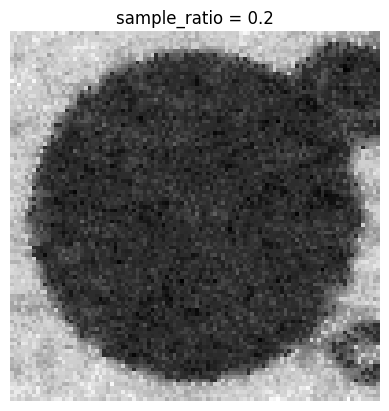

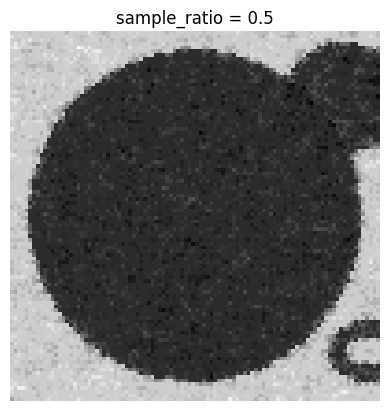

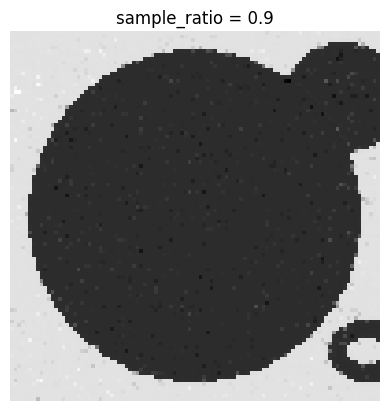

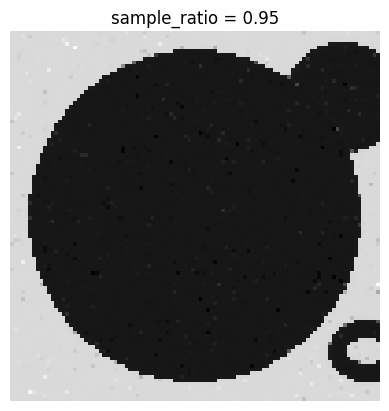

In [15]:
for i,sample_ratio in enumerate([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9, 0.95]):
    reconstruct_map = cs_predict(map_bmp, sample_ratio)
    plt.figure(i+1)
    img = plt.imshow(reconstruct_map)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title(f'sample_ratio = {sample_ratio}')
    plt.show()

In [16]:
dct_map = dct2(map_bmp)

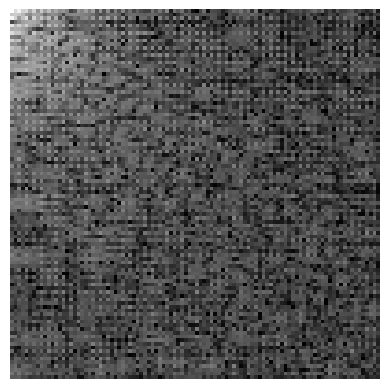

In [17]:
F = np.log(np.abs(dct_map)+1) # Put FFT on log scale
plt.imshow(F,cmap='gray')
plt.axis('off')
plt.show()

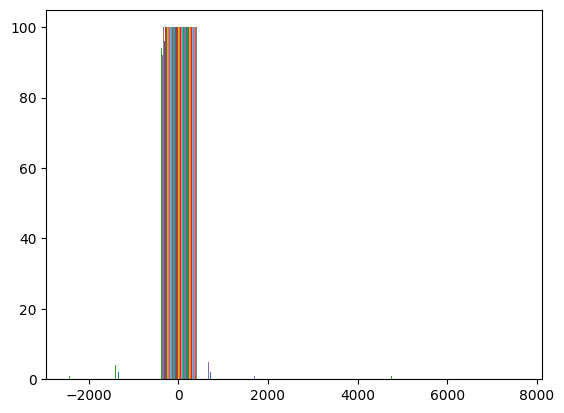

In [18]:
plt.hist(dct_map);

In [19]:
np.min(dct_map), np.max(dct_map)

(-2546.2187238484407, 7716.3)

In [20]:
# compress q-table (for given compression factor)
def compress_dct(Abw, keep):
    ## Compute FFT of image using fft2
    At = dct2(Abw)
    
    ## Zero out all small coefficients and inverse transform
    Bt = np.sort(np.abs(np.reshape(At,-1)))
    thresh = Bt[int(np.floor((1-keep)*len(Bt)))]
    ind = np.abs(At) > thresh
    Atlow = At * ind

    ## Inverse FFT
    Alow = idct2(Atlow)

    return Alow

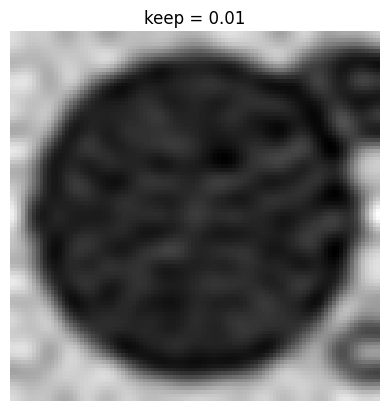

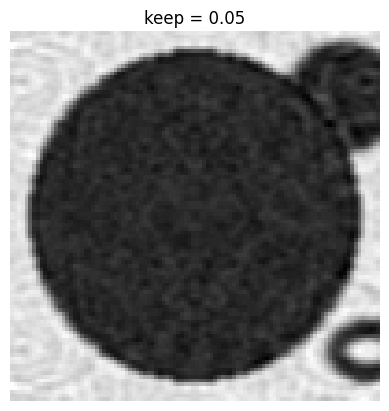

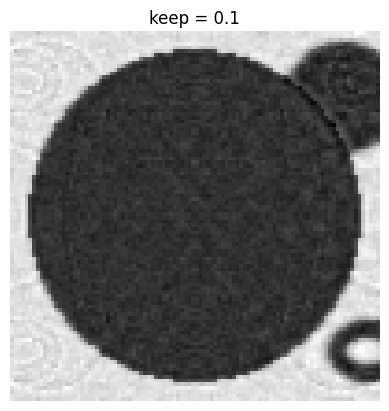

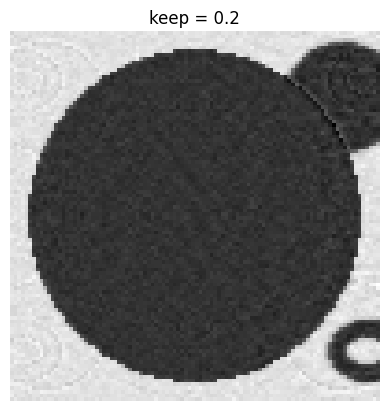

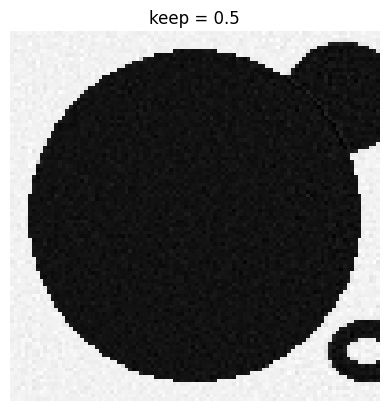

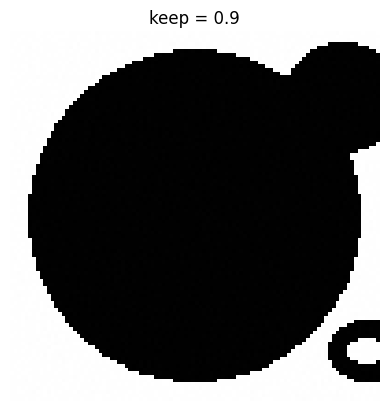

In [21]:
for i,keep in enumerate([0.01, 0.05, 0.1, 0.2, 0.5, 0.9]):
    compressed_map = compress_dct(map_bmp, keep)
    plt.figure(i+1)
    img = plt.imshow(compressed_map)
    img.set_cmap('gray')
    plt.axis('off')
    plt.title(f'keep = {keep}')
    plt.show()
# viz_qtable(compressed_qtable, f"Keep = {keep}")